In [169]:


import _init_paths
from PIL import Image
import numpy as np
import cv2
import random
import copy

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.trackers import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])
        
visualizer = Correspondence_Visualizer(mode='flow', radius=3)
visualizer_hr = Correspondence_Visualizer(mode='flow', scale=64, radius=3)

output_dir = '/home/lr/project/vcl_output/vis_flow'

if os.path.exists(output_dir): os.makedirs(output_dir, exist_ok=True)



def main(x1, x2, model, frame1, frame2, gt):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    plt = visualizer.visualize([enc1, enc2], [x1, x2], [frame1, frame2], gt)
    # visualize_correspondence_quant(enc1, enc2, sample_idx, frame1, frame2, scale=32)
    return plt

def main_hr(x1, x2, model, frame1, frame2, gt):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    plt = visualizer_hr.visualize([enc1, enc2], [x1, x2], [frame1, frame2], gt)
    return plt

In [170]:
## sample frame
import glob
import os.path as osp

# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]
frame2 = cv2.imread(sample['frames_path'][frame_idx+1])[:,:,::-1]
gt = cv2.imread(sample['frames_path'][frame_idx].replace('JPEGImages', 'Flows_s256'))


frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))
gt = cv2.resize(gt, (256,256))[:,:,1:].astype(np.float32) / 255 - 0.5


print('sample frames from {}'.format(sample['frames_path'][0]))

x1_rgb = preprocess_(frame1, mode='rgb')
x2_rgb = preprocess_(frame2, mode='rgb')

x1_lab = preprocess_(frame1, mode='lab')
x2_lab = preprocess_(frame2, mode='lab')

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/2bf545c2f5/00000.jpg


2022-10-14 16:07:59,369 - vcl - INFO - Loading /home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth not as torchvision
2022-10-14 16:07:59,369 - vcl - INFO - load checkpoint from local path: /home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth
2022-10-14 16:07:59,397 - vcl - INFO - 
backbone.conv1.conv.weight - torch.Size([64, 3, 7, 7]): 
Initialized by user-defined `init_weights` in ResNet  
 
2022-10-14 16:07:59,397 - vcl - INFO - 
backbone.conv1.bn.weight - torch.Size([64]): 
Initialized by user-defined `init_weights` in ResNet  
 
2022-10-14 16:07:59,397 - vcl - INFO - 
backbone.conv1.bn.bias - torch.Size([64]): 
Initialized by user-defined `init_weights` in ResNet  
 
2022-10-14 16:07:59,398 - vcl - INFO - 
backbone.layer1.0.conv1.conv.weight - torch.Size([64, 64, 3, 3]): 
Initialized by user-defined `init_weights` in ResNet  
 
2022-10-14 16:07:59,398 - vcl - INFO - 
backbone.layer1.0.conv1.bn.weight - torch.Size([64]): 
Initial

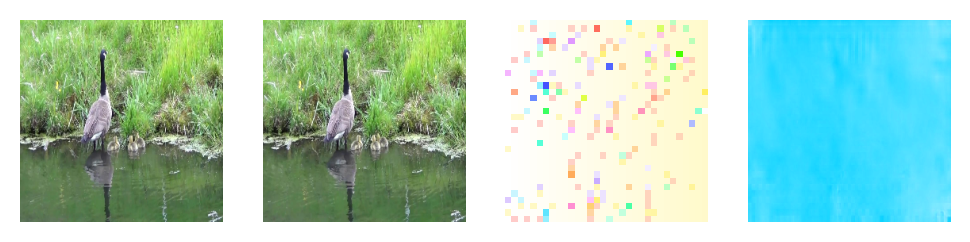

In [171]:

model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 2, 1), out_indices=(2, ), pool_type='none', pretrained='/home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth', torchvision_pretrain=False),
    test_cfg=dict(),
    train_cfg=dict()
    )
model.init_weights()

model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)

2022-10-14 16:07:59,959 - vcl - INFO - Loading /home/lr/expdir/VCL/group_stsl_former/dist_nl_l2_layer4_mast_d2/epoch_1600.pth not as torchvision
2022-10-14 16:07:59,959 - vcl - INFO - load checkpoint from local path: /home/lr/expdir/VCL/group_stsl_former/dist_nl_l2_layer4_mast_d2/epoch_1600.pth
2022-10-14 16:08:00,035 - vcl - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: backbone_t.conv1.conv.weight, backbone_t.conv1.bn.weight, backbone_t.conv1.bn.bias, backbone_t.conv1.bn.running_mean, backbone_t.conv1.bn.running_var, backbone_t.conv1.bn.num_batches_tracked, backbone_t.layer1.0.conv1.conv.weight, backbone_t.layer1.0.conv1.bn.weight, backbone_t.layer1.0.conv1.bn.bias, backbone_t.layer1.0.conv1.bn.running_mean, backbone_t.layer1.0.conv1.bn.running_var, backbone_t.layer1.0.conv1.bn.num_batches_tracked, backbone_t.layer1.0.conv2.conv.weight, backbone_t.layer1.0.conv2.bn.weight, backbone_t.layer1.0.conv2.bn.bias, backbone_t.layer1.0.co

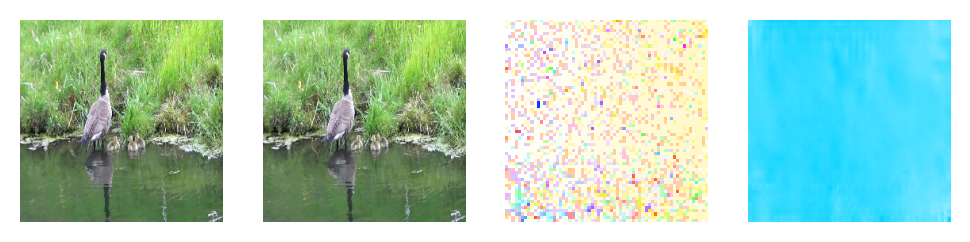

In [172]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 1, 1, 1), out_indices=(2, ), pool_type='mean', pretrained='/home/lr/expdir/VCL/group_stsl_former/dist_nl_l2_layer4_mast_d2/epoch_1600.pth', torchvision_pretrain=False),
    test_cfg=dict(),
    train_cfg=dict()
    )
model.init_weights()


model = model.cuda()
model.eval()
plt = main_hr(x1_lab, x2_lab, model, frame1, frame2, gt)